In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt




In [2]:
# Hyper-parameters initialization

IMAGE_SIZE = 28*28
NUM_CLASSES = 10
MAX_EPOCH = 5
BATCH_SIZE = 100
LEARNING_RATE = 0.005

In [3]:
class LogisticRegression(nn.Module):

    def __init__(self,input_size,num_classes):
        super(LogisticRegression, self).__init__()
        # 1 input image : 28*28 , output is 10 classes
        self.linear = nn.Linear(in_features=IMAGE_SIZE, out_features=NUM_CLASSES,bias=True)
        
    def forward(self, x):
        return self.linear(x)



In [4]:
#Download MNIST dataset
ROOT = "data/"

#transforms.ToTensor() transforms the PIL.Image.Image format to pytorch Tensor 

train_MINST = MNIST(ROOT+"MNIST", train=True, download=True,transform=transforms.ToTensor())
test_MINST = MNIST(ROOT+"MNIST", train=False, download=True,transform=transforms.ToTensor())


train_data_loader = torch.utils.data.DataLoader(train_MINST,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_MINST,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)


In [5]:
#Before iterating all the training set, verfiy the dimensions of the training and target tensors of a random example
(images, labels) = list(train_data_loader)[0]
# images shape now is [BATCH_SIZE, 1, 28, 28], it should be reshaped ot [BATCH_SIZE,IMAGE_SIZE]
images = images.reshape(-1,IMAGE_SIZE)
print(images.shape)
print(labels.shape)
assert images.shape[0] == BATCH_SIZE
assert images.shape[1] == IMAGE_SIZE
assert labels.shape[0] == BATCH_SIZE


torch.Size([100, 784])
torch.Size([100])


## How PyTorch calculates Cross Entropy

Pytorch calculates the softmax of the output first before calculating the cross entropy.

For example, assume we have four classes and the output of the model is something like [0,0,0,1] and the actual target is [3]. Calculating the cross entropy directly should equal to zero (1*log(1)). 

However, PyTorch converts the outputs to probabilities that sums to 1 using softmax: 
softmax([0,0,0,1]) =  [0.1749,0.1749,0.1749,0.4754]
Then, apply the cross entropy formula -log(0.4754) = 0.7437

Reference: https://stackoverflow.com/questions/49390842/cross-entropy-in-pytorch


In [6]:
output = Variable(torch.FloatTensor([0,0,0,1])).view(1, -1)
target = Variable(torch.LongTensor([3]))

criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
print(loss)
del loss

tensor(0.7437)


## Train a simple logistic regression model
$$y_{m*c} = x_{m*n} * w_{n*c} + b_{m*c}$$
where $m$ is the number of examples (i.e. the number of the training images), $n$ is the number of features (i.e. the image size) and $c$ is the number of the classes

Note that $b$ have the same values that are broadcasted to all the examples $m$.

In [10]:
lr_model = LogisticRegression(IMAGE_SIZE, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=LEARNING_RATE)  

for epoch in range(0,MAX_EPOCH):
    #train_data_loader is already partitioned to multiple batches, each batch with size = LENGTH(TRAINING_SET)/BATCH_SIZE
    for batch_index, (images, labels) in enumerate(train_data_loader):
        images = Variable(images.reshape(-1, 28*28),requires_grad=True)
        labels = Variable(labels)

        #reset the gradients to zero
        optimizer.zero_grad()
        
        #calculate predictions (y^)
        predictions = lr_model(images)
        
        #calculate Cross Entropy loss between labels(y) and predictions(y^)
        loss = criterion(predictions, labels)
        
        #Backward propagation
        loss.backward()
        optimizer.step()

In [13]:
# get the learned weights vector w
w = list(lr_model.parameters())[0]

assert w.shape[0] == NUM_CLASSES
assert w.shape[1] == IMAGE_SIZE

# get the learned bias vector b
b = list(lr_model.parameters())[1]

assert b.shape[0] == NUM_CLASSES

In [12]:
# Test the model accuracy
correct_instances = 0
total_test_examples = 0
for images, labels in test_data_loader:
    images = Variable(images.reshape(-1, 28*28))
    predictions_output = lr_model(images)
    _, predicted_classes = torch.max(predictions_output.data, 1)
    total_test_examples = total_test_examples + len(images)
    correct_instances = correct_instances + (predicted_classes == labels).sum()

print('Number of correct classified test images: %d %%' % (100 * correct_instances / total_test_examples))

Number of correct classified test images: 87 %


In [49]:
def visualize_model(lr_model,dataloaders, num_images=6):
    was_training = lr_model.training
    lr_model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.reshape(-1,IMAGE_SIZE)
            outputs = lr_model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j]))
                plt.imshow(inputs.reshape(-1,28,28).data[j])

                if images_so_far == num_images:
                    lr_model.train(mode=was_training)
                    return
        lr_model.train(mode=was_training)

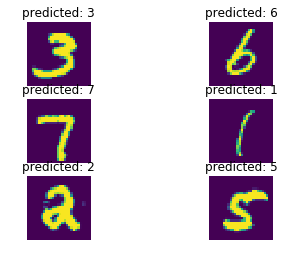

In [50]:
visualize_model(lr_model,train_data_loader)
#train_data_loader
